<h1 align="center">Midterm</h1>

You will be doing an intensive analysis of consumer behavioral, applying techniques ranging from supervised, unsupervised learning, as well as semi-supervised learning.

## Data

The data is in `dat/online_shoppers_intention.csv.gz`, from [Online Shoppers Purchasing Intention Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset)

- The dataset consists of 10 numerical and 8 categorical variables.
- Variable `Revenue` is the target label. This binary variable is imbalanced, specifically 84.5% of user journeys did NOT result in a purchase; in other words `Revenue` is False.
- `Administrative`, `Administrative Duration`, `Informational`, `Informational Duration`, `Product Related`, and `Product Related Duration` represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. 
- The values of these features are derived from the URL information of the pages visited by the user and updated when a user takes an action, e.g, moving from one page to another. 
- Features `Bounce Rate`, `Exit Rate` and `Page Value` represent  metrics measured by Google Analytics for each page in the e-commerce site. 
- The value of `Bounce Rate` for a web page refers to the percentage of visitors who enter the site from that page and then leave (i.e., bounce) without triggering any other requests to the analytics server during that session. 
- The value of `Exit Rate` for a specific web page is calculated as for all page views to the page and it represents the percentage that the page was seen in the last session. 
- Feature `Page Value` represents the average value for a web page that a user visited before completing an e-commerce transaction. 
- Feature `Special Day` indicates the closeness of the site visiting time to a specific special day (e.g., Mother’s Day or Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. 
- The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a boolean value indicating whether the date of the visit is weekend, and month of the year.

## Preparation

In [1]:
# import libraries for assignments
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.semi_supervised import LabelSpreading
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import get_config

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

# warnings suppress
import warnings
warnings.filterwarnings('ignore')


## Load data

In [2]:
data = pd.read_csv(filepath_or_buffer="../dat/online_shoppers_intention.csv.gz")
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
# check the columns and length of dataset
print(f"Column names in dataset:\n {data.columns}")
print(f"Total number of columns: {len(data.columns)}")
print(f"Length of dataset: {len(data)}")

Column names in dataset:
 Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')
Total number of columns: 18
Length of dataset: 12330


Total number of columns is 18 inline with data description above.

Check null values in dataset:

In [4]:
print(f"Summary of null values in dataset:\n {data.isnull().sum()}")

Summary of null values in dataset:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


No null values has been found!

One of interesting thing to be considered is type of data:

In [5]:
# check datatype
dict(data.dtypes)

{'Administrative': dtype('int64'),
 'Administrative_Duration': dtype('float64'),
 'Informational': dtype('int64'),
 'Informational_Duration': dtype('float64'),
 'ProductRelated': dtype('int64'),
 'ProductRelated_Duration': dtype('float64'),
 'BounceRates': dtype('float64'),
 'ExitRates': dtype('float64'),
 'PageValues': dtype('float64'),
 'SpecialDay': dtype('float64'),
 'Month': dtype('O'),
 'OperatingSystems': dtype('int64'),
 'Browser': dtype('int64'),
 'Region': dtype('int64'),
 'TrafficType': dtype('int64'),
 'VisitorType': dtype('O'),
 'Weekend': dtype('bool'),
 'Revenue': dtype('bool')}

From the datatype, categorical features are: `Weekend`, `VisitorType`, `Month`. Other features are numeric.

Now let's check the unique values of each categorical features:

In [6]:
print(f"Unique features of Weekend: {data.Weekend.unique()}")
print(f"Unique features of VisitorType: {data.VisitorType.unique()}")
print(f"Unique features of Moth: {data.Month.unique()}")


Unique features of Weekend: [False  True]
Unique features of VisitorType: ['Returning_Visitor' 'New_Visitor' 'Other']
Unique features of Moth: ['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']


Let's convert these features to numerics:

In [7]:
data.Weekend = data.Weekend.replace({False:0, True:1})
data.VisitorType = data.VisitorType.replace({"New_Visitor": 1, "Returning_Visitor":2, "Other":3})
data.Month = data.Month.replace({'Feb':2, 'Mar':3, 'May':5, 'June':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12})


also convert our label to number, False to be 0 and True to be 1.

In [8]:
# convert label to numeric
data["Revenue"] = data["Revenue"].replace({False: 0, True: 1})


Using `describe` method to see data statistic:

In [9]:
# data statistic
data.describe().T


,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


From the data statistic above, It seems to have seven continuous variables and the rest are categorical variables.

In [10]:
# percentage of purchase in dataset
print(f"The percentage of purchase in dataset: {data.Revenue.mean():%}")


The percentage of purchase in dataset: 15.474453%


The dataset is imbalanced. Only 15.5% samples is class 1 and 84.5% is class 0. 

Let's split dataset into training and testing and doing deep analysis for train set:

In [11]:
# split data
train_data = data[data.Month >= 6]
test_data = data[(data.Month >=2) & (data.Month <= 3)]

# shape
(train_data.shape, test_data.shape)

((6875, 18), (2091, 18))

The number of each class in train and test set:

In [12]:
print(f"The percentage of purchase in train dataset: {train_data.Revenue.mean():%}")
print(f"The percentage of purchase in test dataset: {test_data.Revenue.mean():%}")

The percentage of purchase in train dataset: 19.607273%
The percentage of purchase in test dataset: 9.325681%


Check the correlation in training set:

Text(0.5, 1.0, 'Correlation Matrix of training set')

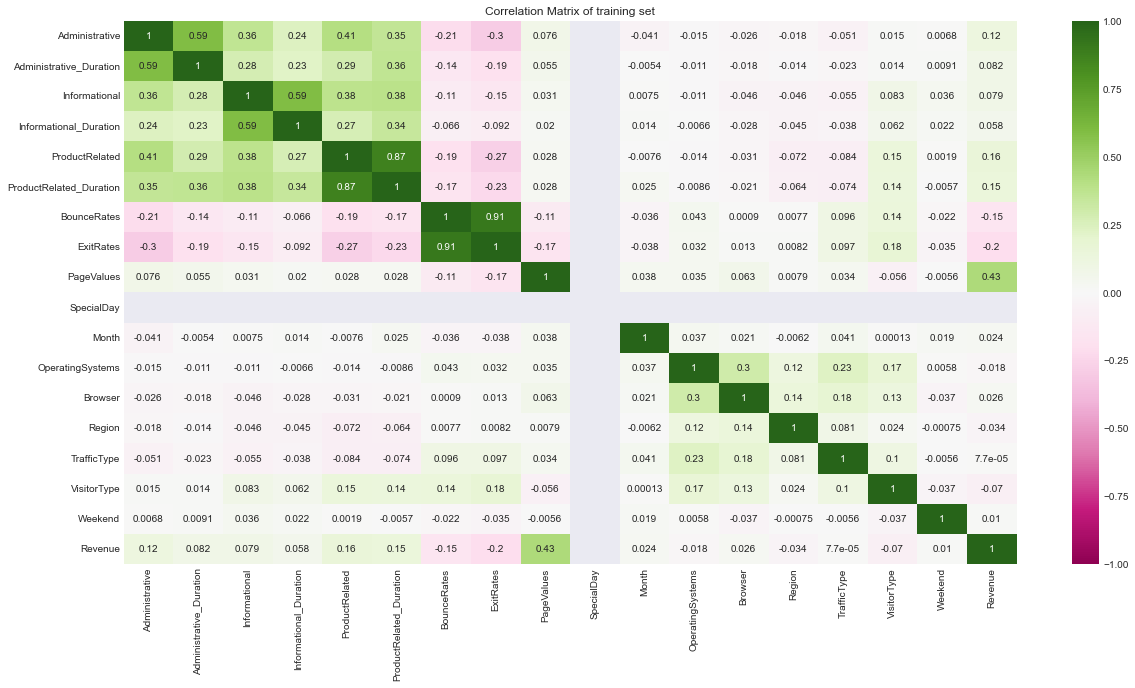

In [13]:
cors = train_data.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(cors, annot=True, vmin=-1, vmax=1, cmap='PiYG')
plt.title("Correlation Matrix of training set")

From above figure, with threshold of 0.8, I found that `ProductRelated` and `ProductRelated_Duration` are collinear, and `BounceRates` and `ExitRates` are also collinear. Looking at labels, `Revenue`, we decide
to keep `ProductRelated` and `ExitRates` due to its absolute values are higher than its peers.

`SpecialDay` seems to have a constant value in training set.


Define features and labels:

In [14]:
# define feature and label
features = [col for col in train_data.columns if col not in ["Revenue", "ProductRelated_Duration", "BounceRates"]]
labels = "Revenue"

# train set and test set
X_train = train_data[features].values
X_test = test_data[features].values

y_train = train_data[labels].values
y_test = test_data[labels].values


## Task 1: Classification

Build a predictive classification model using data entries corresponding to the months of June—December as training set, and those corresponding to February—March as test set. 

More specifically,

1. Fit a logistic regression and at least one other classification model. Find and explain important features. 
1. Report and interpret the most meaningful classifications metrics
1. Show and explain the hyper-parameter fitting process.

### Logistic Regression

In [15]:
# define logistic regression
log_reg = Pipeline(
    steps=[("scaler", MinMaxScaler()),
    ("logistic", LogisticRegression(C=100, random_state=42))
    ]
)

log_reg.fit(X_train, y_train)
preds_log = log_reg.predict(X_test)
print("Logistic regression accuracy: ", accuracy_score(y_test, preds_log))

Logistic regression accuracy:  0.9306551889048302


Model accuracy is far above dummny classifier. As a humman, if I alway predict revenue as 0, I will get almost 85% correct answer over the dataset. 
So the logistic regression has 9% higher than. It's nice model! But, we need to explore other metrics to have a deeper understand.

In [16]:
print("Classification report: \n", classification_report(y_test, preds_log))


Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      1896
           1       0.77      0.37      0.50       195

    accuracy                           0.93      2091
   macro avg       0.85      0.68      0.73      2091
weighted avg       0.92      0.93      0.92      2091



Optimize Logistic regression by RandomnizedSearch:

In [17]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV

params_log = {
    "logistic__C": [0.01, 0.1, 1, 10, 50, 100, 500],
    "logistic__class_weight": ["balalance", {0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}]
}

cv = StratifiedKFold(n_splits=5)

randomsearch_log = GridSearchCV(estimator=log_reg, param_grid=params_log, cv=cv, scoring="accuracy")
randomsearch_log.fit(X_train, y_train)
log_estimator = randomsearch_log.best_estimator_
preds_log = log_estimator.predict(X_test)
print("Best Logistic classifier accuracy: ", accuracy_score(y_test, preds_log))
print("Best logistic params:")
print(randomsearch_log.best_params_)


Best Logistic classifier accuracy:  0.937350549976088
Best logistic params:
{'logistic__C': 100, 'logistic__class_weight': {0: 1, 1: 2}}


Eplore the logistic coefficients during fitting:

In [18]:
coefs = log_estimator["logistic"].coef_
intercept = log_estimator["logistic"].intercept_
print("Logistic Regression params: ")
# convert to dataframe
coefs_df = pd.DataFrame(zip(features + ["intercept_"], coefs.tolist()[0] + intercept.tolist()), columns=["Features", "Values"])
coefs_df.set_index("Features").sort_values(by="Values",ascending=False)

Logistic Regression params: 


,Values
Features,
PageValues,26.149486
ProductRelated,3.943796
Browser,0.398251
Administrative,0.287245
Informational,0.254991
TrafficType,0.241364
Informational_Duration,0.214425
Weekend,0.107017
Month,0.044132


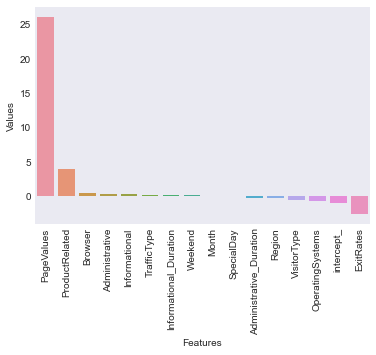

In [19]:
coefs_df = coefs_df.set_index("Features").sort_values(by="Values", ascending=False)
g=sns.barplot(x=coefs_df.index, y=coefs_df["Values"])
plt.xticks(rotation=90)
plt.show(g)

As expected from heatmap, `SpecialDay` has no effect to model output when its weight is zero. ExitRates have worst impact on output. Don't forget intercept_ is constant.

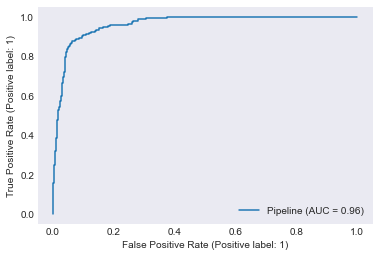

In [20]:
plot_roc_curve(log_estimator, X_test, y_test)


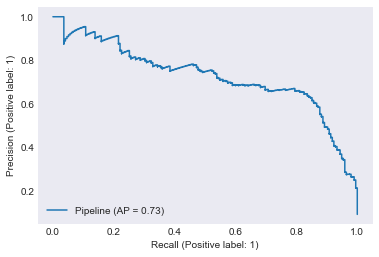

In [21]:
plot_precision_recall_curve(log_estimator, X_test, y_test)


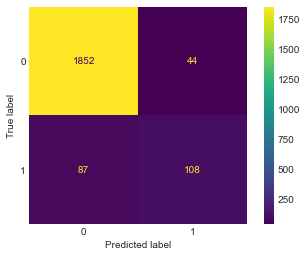

In [22]:
conf_ = confusion_matrix(y_test, preds_log)
disp = ConfusionMatrixDisplay(conf_)
disp.plot()

Let's try another non-linear method.

### Non Linear classification models

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

gbt = Pipeline(
    steps=[("scaler", MinMaxScaler()),
    ("gbt", GradientBoostingClassifier(random_state=42))
    ]
)
#hist = HistGradientBoostingClassifier(max_depth=7, min_samples_leaf=10, max_leaf_nodes=50, random_state=42)
gbt.fit(X_train, y_train)

preds_gbt = gbt.predict(X_test)
print("GradientBoosting classifier accuracy: ", accuracy_score(y_test, preds_gbt))


GradientBoosting classifier accuracy:  0.9421329507412721


In Gradient Boost model, GradientBoosting was used with default params to classify labels. Accuracy is almost similar to Logistic regression.
Now let's try to optimize GradientBoosting with RandomnizedSearchCV method from sklearn.

In [24]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

params_log = {
    "gbt__n_estimators": np.arange(100, 500, 20),
    "gbt__learning_rate": np.random.uniform(0.001, 0.5, 5),
    "gbt__subsample": np.random.uniform(0.5, 1, 5),
    "gbt__max_depth": [3, 4, 5, 6, 7],
    "gbt__min_samples_split": np.arange(2, 10, 2),
    "gbt__max_leaf_nodes": np.arange(20, 26, 2),
    "gbt__min_samples_leaf": np.random.uniform(0.01, 0.2, 3),
    "gbt__min_weight_fraction_leaf": np.random.uniform(0.01, 0.5, 5),
    "gbt__max_features": [0.1, 0.5, 1.]
}

cv = StratifiedKFold(n_splits=5)

randomsearch_gbt = RandomizedSearchCV(estimator=gbt, param_distributions=params_log, cv=cv, scoring="accuracy", random_state=42, n_iter=20)
randomsearch_gbt.fit(X_train, y_train)
gbt_estimator = randomsearch_gbt.best_estimator_
preds_gbt = gbt_estimator.predict(X_test)
print("GradientBoosting classifier accuracy: ", accuracy_score(y_test, preds_gbt))
print(randomsearch_gbt.best_params_)


GradientBoosting classifier accuracy:  0.945480631276901
{'gbt__subsample': 0.7276353877021977, 'gbt__n_estimators': 480, 'gbt__min_weight_fraction_leaf': 0.12247184883109209, 'gbt__min_samples_split': 6, 'gbt__min_samples_leaf': 0.13700455507475703, 'gbt__max_leaf_nodes': 24, 'gbt__max_features': 0.5, 'gbt__max_depth': 3, 'gbt__learning_rate': 0.13180979090562564}


In [141]:
print("GradientBoosting Classification report: \n", classification_report(y_test, preds_gbt))

GradientBoosting Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1896
           1       0.73      0.65      0.69       195

    accuracy                           0.95      2091
   macro avg       0.85      0.81      0.83      2091
weighted avg       0.94      0.95      0.94      2091



In [25]:
print("GradientBootingClassifier Feature importances:")
importances_df = pd.DataFrame(zip(features,gbt_estimator["gbt"].feature_importances_), columns=["Features", "Importances"])
importances_df.set_index("Features", inplace=True)
importances_df.sort_values(by="Importances", ascending=False)

GradientBootingClassifier Feature importances:


,Importances
Features,
PageValues,0.684010
ExitRates,0.107135
ProductRelated,0.047518
Administrative_Duration,0.044919
Administrative,0.040978
Month,0.037487
TrafficType,0.016181
Region,0.010222
OperatingSystems,0.003911


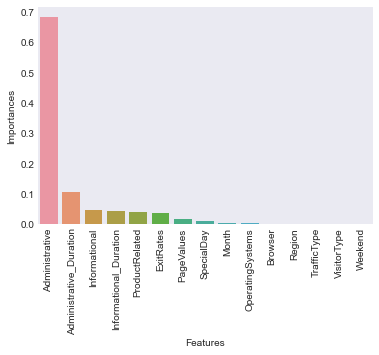

In [26]:
g=sns.barplot(x=importances_df.index, y=importances_df["Importances"].sort_values(ascending=False))
plt.xticks(rotation=90)
plt.show(g)

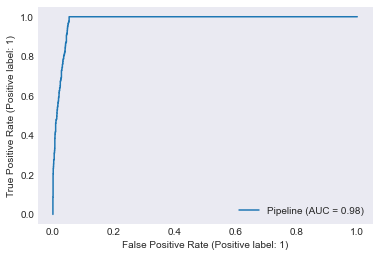

In [27]:
plot_roc_curve(gbt_estimator, X_test, y_test)

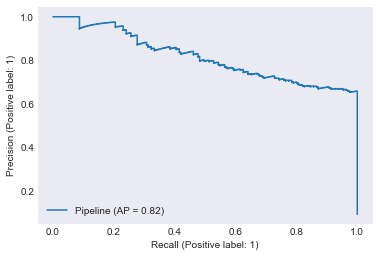

In [28]:
plot_precision_recall_curve(gbt_estimator, X_test, y_test)

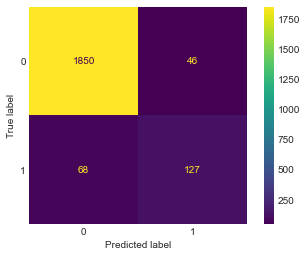

In [29]:
conf_gbt = confusion_matrix(y_test, preds_gbt)
disp_gbt = ConfusionMatrixDisplay(conf_gbt)
disp_gbt.plot()

## Task 2

Generate user-behavior clusters based on the purchasing behavior data for the complete dataset. 

1. How many clusters do you see? What are the significant differences between the various clusters in terms of the size of the clusters and purchase ratio. Perform as detailed analysis of the clusters as you can.
2. Return plots and cluster images generated for the data.
3. Perform a detailed analysis for each cluster corresponding to the variations in features and identify some behaviors corresponding to each particular cluster (e.g., which cluster represent new shoppers vs. brand conscious shoppers etc.).

Fitting a clustering model and find the best k values:

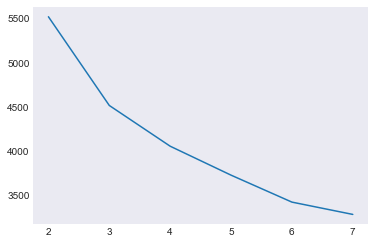

In [61]:
# define X
X = data[features].values
X = MinMaxScaler().fit_transform(X)

inerteria = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inerteria.append(kmeans.inertia_)

plt.plot(range(2,8), inerteria)    
plt.show();


For n_clusters = 2 The average silhouette_score is : 0.3477664235826329
For n_clusters = 3 The average silhouette_score is : 0.2608957624278526
For n_clusters = 4 The average silhouette_score is : 0.2549383546114854
For n_clusters = 5 The average silhouette_score is : 0.26226909707024526
For n_clusters = 6 The average silhouette_score is : 0.2564116019457726


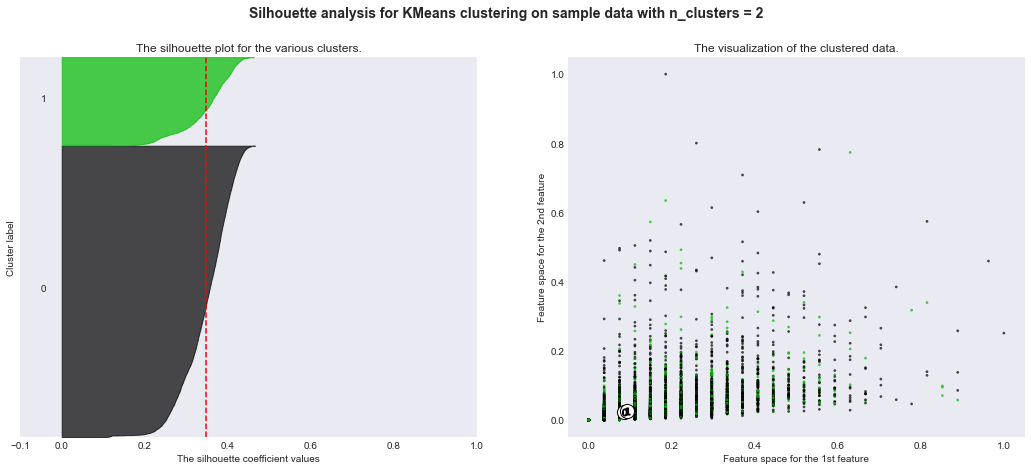

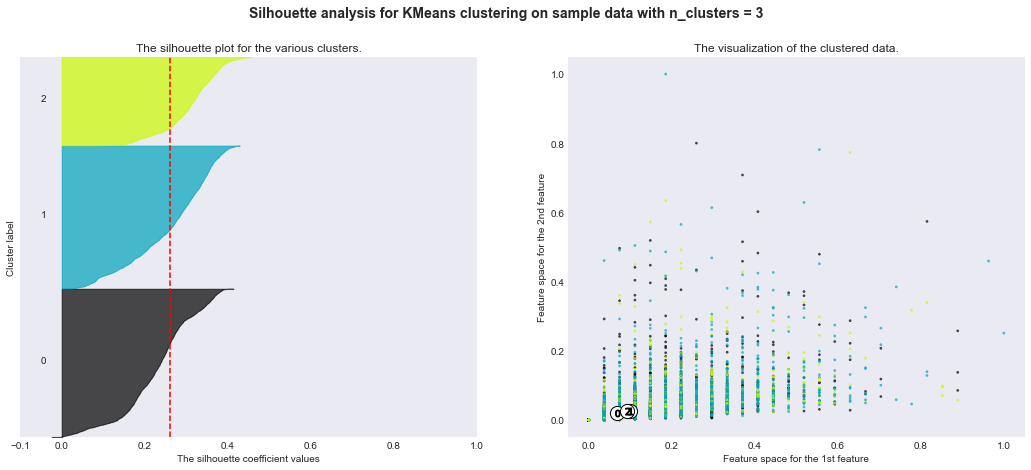

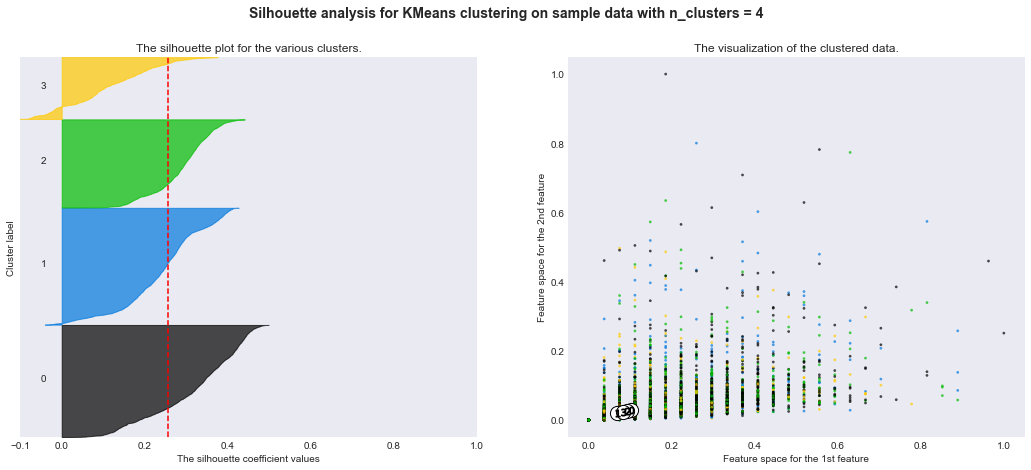

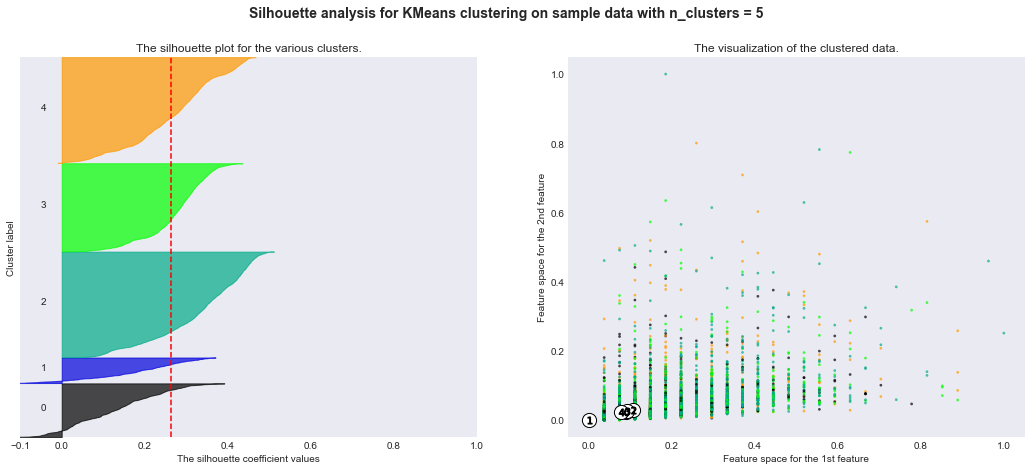

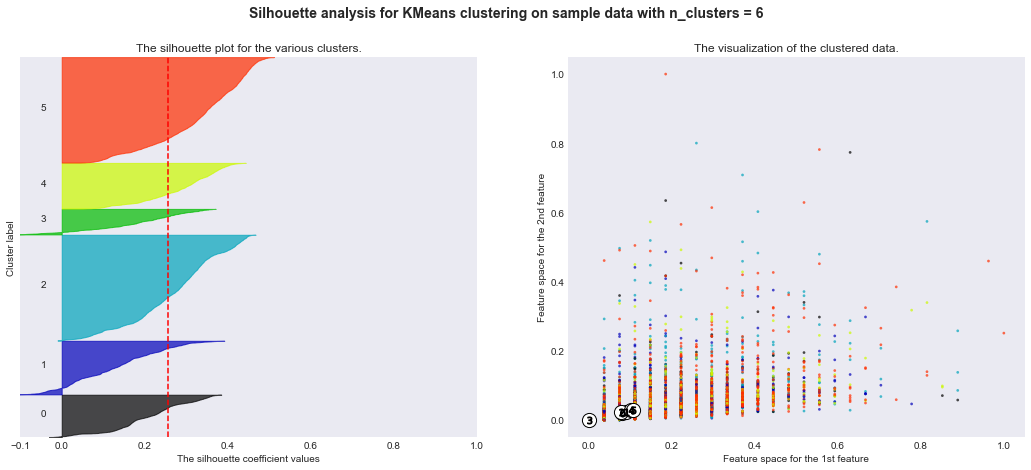

In [62]:
from utils import visualize_silhouette
visualize_silhouette(max_clusters=6, X=X)


Based on the cluster size, KMeans is the suitable method for this problem. Regarding inerteria_ and cluster size, the optimal n_clusters is 3.

Let's instantiate the new model with n_clusters = 3:

In [109]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
preds_kmeans = kmeans.predict(X)

# transfers prediction to dataframe
data["cluster"] = preds_kmeans
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,cluster
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,0,0,2
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,0,0,2
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,0,0,2
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,0,0,2
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,1,0,0


Doing some analysis to see if clustering help to identify some pattern:

In [110]:
sum_df = data.groupby(['cluster'])\
                                .agg(count = ('cluster', 'size'), 
                                Purchase= ('Revenue','mean'),
                                Weekend=('Weekend', 'mean'),
                                SpeicalDay=('SpecialDay', 'mean'),
                                OS = ('OperatingSystems', 'mean'),
                                VisitorType=('VisitorType', 'mean'),
                                ProductRelated=('ProductRelated', 'mean'),
                                TrafficType = ('TrafficType', 'mean'),
                                Region = ('Region', 'mean'),
                                PageValues = ('PageValues', 'mean'),
                                ).sort_values(by="Purchase")


In [111]:
sum_df

,count,Purchase,Weekend,SpeicalDay,OS,VisitorType,ProductRelated,TrafficType,Region,PageValues
cluster,,,,,,,,,,
2,4820,0.097095,0.0,0.124191,2.102282,1.908714,24.655394,3.962241,3.113071,4.325642
0,2868,0.173989,1.0,0.055370,2.124477,1.835425,33.031381,4.053347,3.144351,6.294020
1,4642,0.202714,0.0,0.000000,2.146273,1.849849,38.275743,4.191081,3.184834,7.262754


<AxesSubplot:xlabel='cluster'>

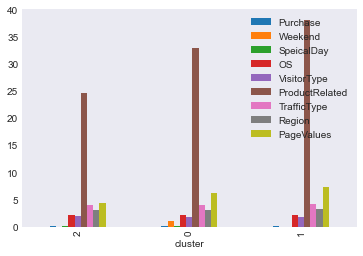

In [112]:
sum_df.drop(columns="count").sort_values(by="Purchase").plot(kind='bar')

Based on cluster analysis, I found that:
- Only group 2 (cluster 2) made purchase at weekend other group didn't. 
- PageValues are high relating to high purchase rate.
- Higher ProductRelated means higher purchase rate.
- TrafficType and Region also have same trend with PageValues.
- One interesting thing is higher SpecialDay rate resulting lower purchase rate.


# Task 3

Consider you have training data with the `Revenue` attribute for records from June—September only. For all records from October—December, however, `Revenue` attribute is missing. Build a semi-supervised self-labeling model to estimate `Revenue` for the missing records in October—December and then fit your classifier. Report classification performance on February—March data set with and without the self-labeled data.

1. If you do not consider the records from October—December, generate the classification performance on test data
2. After using the self-labeled data and training data together, does the classification performance on test data improve? Discuss which metrics are most important for your conclusion.

Create a dummy dataset:

In [118]:
# make dummy labels
semi_train_data = train_data.copy()
for i in semi_train_data.index:
    if semi_train_data.loc[i, "Month"] > 9:
        semi_train_data.loc[i, "Revenue"] = -1

semi_train_data[semi_train_data["Month"] > 9].head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5455,0,0.0,0,0.0,1,207.570248,0.0,0.007937,0.000000,0.0,10,2,2,1,5,2,0,-1
5457,1,63.4,0,0.0,3,120.400000,0.0,0.000000,42.293068,0.0,10,1,1,3,3,1,0,-1
5461,7,56.3,0,0.0,15,315.400000,0.0,0.011111,0.000000,0.0,10,2,2,1,2,1,0,-1
5463,1,39.2,2,120.8,7,80.500000,0.0,0.010000,0.000000,0.0,11,3,2,4,2,1,1,-1
5464,3,89.6,0,0.0,57,1721.906667,0.0,0.005932,204.007949,0.0,11,2,2,1,4,2,1,-1


The results are as expected!

Create a semi-supervised model:

In [148]:
# define model
label_spread = LabelSpreading(kernel="knn", gamma=.01, alpha=0.1)

# define X and y
X_semi = semi_train_data[features].values
y_semi = semi_train_data[labels].values

# fitting
label_spread.fit(X_semi, y_semi)

# prediction
preds_semi = label_spread.predict(X_test)
print("Semi-Supervised classifier accuracy: ", accuracy_score(y_test, preds_semi))


Semi-Supervised classifier accuracy:  0.9225251076040172


Optimize Semi-Supervised model:

In [149]:
params_semi = {
    "kernel": ["rbf", "knn"],
    "n_neighbors": np.arange(2, 30, 1),
    "gamma": np.random.uniform(0.0001, 30, 100),
    "alpha": np.random.uniform(0.0001, 1, 20)
}

cv = StratifiedKFold(n_splits=5)

randomsearch_semi = RandomizedSearchCV(estimator=label_spread, param_distributions=params_semi, cv=cv, scoring="accuracy")
randomsearch_semi.fit(X_semi, y_semi)
semi_estimator = randomsearch_semi.best_estimator_
preds_semi = semi_estimator.predict(X_test)
print("Best Semi-Supervised classifier accuracy: ", accuracy_score(y_test, preds_semi))
print("Best Semi-Supervised params:")
print(randomsearch_semi.best_params_)

Best Semi-Supervised classifier accuracy:  0.9344811095169775
Best Semi-Supervised params:
{'n_neighbors': 21, 'kernel': 'knn', 'gamma': 9.410512492204525, 'alpha': 0.22966138589040272}


Up to now, the overall accuracy is not improved. But let's look deeper in other metrics:

In [150]:
print("Semi-Supervised Classification report: \n", classification_report(y_test, preds_semi))

Semi-Supervised Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      1896
           1       0.79      0.41      0.54       195

    accuracy                           0.93      2091
   macro avg       0.87      0.70      0.75      2091
weighted avg       0.93      0.93      0.92      2091



Semi-supervised learning underperforms in this case especially class 1! Let's try some other preprocessing method with scaling and pca:

Perform Semi-supervised learning with scaling:

In [151]:
# define model
label_spread = LabelSpreading(kernel="knn", n_neighbors=21, gamma=9.41, alpha=0.2297)

# define X and y
scale = MinMaxScaler()
X_semi_scale = scale.fit_transform(semi_train_data[features].values)
y_semi = semi_train_data[labels].values

# fitting
label_spread.fit(X_semi_scale, y_semi)

# prediction
preds_semi = label_spread.predict(X_test)
print("Semi-Supervised classifier accuracy with scaling data: ", accuracy_score(y_test, preds_semi))


Semi-Supervised classifier accuracy with scaling data:  0.9206121472979436


Perform Semi-supervised learning with PCA:

In [155]:
# define model
label_spread = LabelSpreading(kernel="knn", gamma=8.9, alpha=0.91)

# define X and y
scale = MinMaxScaler()
X_semi_scale = scale.fit_transform(semi_train_data[features].values)
pca = PCA(n_components=0.95)
X_semi_reduced = pca.fit_transform(X_semi_scale)
y_semi = semi_train_data[labels].values

# fitting
label_spread.fit(X_semi_reduced, y_semi)

# prediction
X_test_semi = scale.transform(X_test)
X_test_reduced = pca.transform(X_test_semi)
# prediction
preds_semi = label_spread.predict(X_test_reduced)
print("Semi-Supervised classifier accuracy with reduced data: ", accuracy_score(y_test, preds_semi))

Semi-Supervised classifier accuracy with reduced data:  0.9067431850789096


Below is the classification report of Gradient Boost:

In [142]:
print("GradientBoosting Classification report: \n", classification_report(y_test, preds_gbt))

GradientBoosting Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1896
           1       0.73      0.65      0.69       195

    accuracy                           0.95      2091
   macro avg       0.85      0.81      0.83      2091
weighted avg       0.94      0.95      0.94      2091



In short, Semi-Supervised totaly underperforms comapare to Gradient boost for this problem!

<hr>

**Change Log**

| No. | Rev. | Description | Change by | Date |
| --- | ---- | ----------- | --------- | ---- |
| 1 | 0 | First issue | NguyenS | 2022-06-29 |